# Determinación de tipos de estrellas.

Este segundo caso práctico consiste en desarrollar el algoritmo K–Means. Con el objetivo principal de identificar grupos dentro de los datos, utilizando este método. En esta práctica vamos a explorar diferentes técnicas de aprendizaje no supervisado con datos categóricos ordinales. 

**Autores:**

- 100471948 - Celia Patricio Ferrer
- 100472039 - Alberto García de la Torre

---
## Librerías necesarias.
---

In [106]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# KMeans de sklearn 
from sklearn.cluster import KMeans

# Silhouette
from sklearn.metrics import silhouette_score

# Datos
from sklearn.preprocessing import scale
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Warnings
import warnings
warnings.filterwarnings('ignore')

---
## Lectura del archivo
---

In [68]:
stars_df = pd.read_csv('stars2.csv')

# Visualizar las primeras filas del archivo
stars_df.head()

,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M


Los atributos son:

- `Temperature`: Temperatura promedio de la superficie en grados K.

- `L`: Luminosidad comparada con la del Sol.

- `R`: Radio comparado con la del Sol.

- `A_M`: Magnitud absoluta, brillo aparente de la estrella si estuviera a 10 parsec
de distancia.

- `Color`: Color principal del espectro.

- `Spectral_Class`: Clasificación espectral: es un valor que iden2fica la presencia
elementos químicos en el espectro de la estrella. Es una secuencia (O, B, A, F, G, K, M) que se asocia a las estrellas desde las más calientes O, hasta las más frías M.

### <u>Breve análisis de los datos</u>

Vamos a analizar brevemente el conjunto de datos que tenemos. 

In [69]:
# Imprimir el tamaño del dataframe.
print("El tamaño es:")
print(stars_df.shape)

El tamaño es:
(240, 6)


In [70]:
# Imprimir el tipo de atributos.
stars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB


**Categóricas o numéricas**

Ahora veremos si se tratan de columnas categóricas o columnas numéricas. En función de esto, deberemos manejar de una forma u otra cada una de estas columnas.

In [71]:
cat_columns = stars_df.select_dtypes(include=['object']).columns
num_columns = stars_df.select_dtypes(include=['int64', 'float64']).columns

print("Columnas categoricas:", cat_columns)
print("Columnas numéricas:", num_columns)

Columnas categoricas: Index(['Color', 'Spectral_Class'], dtype='object')
Columnas numéricas: Index(['Temperature', 'L', 'R', 'A_M'], dtype='object')


---
## K–Means
---

En esta primera sección desarrollaremos la implementación de este algoritmo para comparar los resultados y la eficiencia de la implementación de *sklearn*.

In [72]:
class MiKMeans:
    def __init__(self, n_clusters, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X):
        # Inicialización de centroides aleatorios
        centroids_idx = np.random.choice(X.shape[0], size=self.n_clusters, replace=False)
        self.centroids = X[centroids_idx]

        for _ in range(self.max_iter):
            # Asignación de puntos al cluster más cercano
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(distances, axis=1)

            # Actualización de centroides
            new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(self.n_clusters)])

            # Comprobación de convergencia
            if np.allclose(self.centroids, new_centroids):
                break

            self.centroids = new_centroids

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

Esta implementación tiene un método `fit()` para entrenar el modelo y un método `predict()`para predecir las etiquetas de los datos de entrada.

### <u>Comparación</u>

Ahora compararemos nuestra implementación con la implementación de SKlearn.

In [95]:
# Transformar las columnas
cat_transformer = LabelEncoder()
num_transformer = StandardScaler()

# Preprocesamiento
preprocessor = (
    ColumnTransformer([
        ('num', num_transformer, num_columns),
        ('cat', cat_transformer, cat_columns)
    ])
)

En primer lugar, pasaremos las columnas categóricas a numericas para posteriormente, poder aplicar el método `scale`.

In [96]:
X_df = stars_df.copy()
label_encoders = {}

# Aplicar LabelEncoder a cada columna categórica
for col in cat_columns:
    label_encoders[col] = LabelEncoder()
    X_df[col] = cat_transformer.fit_transform(stars_df[col])

# Visualizar las primeras filas del archivo
X_df.head()

,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,8,5
1,3042,0.000500,0.1542,16.60,8,5
2,2600,0.000300,0.1020,18.70,8,5
3,2800,0.000200,0.1600,16.65,8,5
4,1939,0.000138,0.1030,20.06,8,5


Aplicaremos el método `scale`para estandarizar características eliminando la media y escalando a la varianza unitaria.

In [97]:
X_scaled = scale(X_df)

**KMeans de SKlearn**

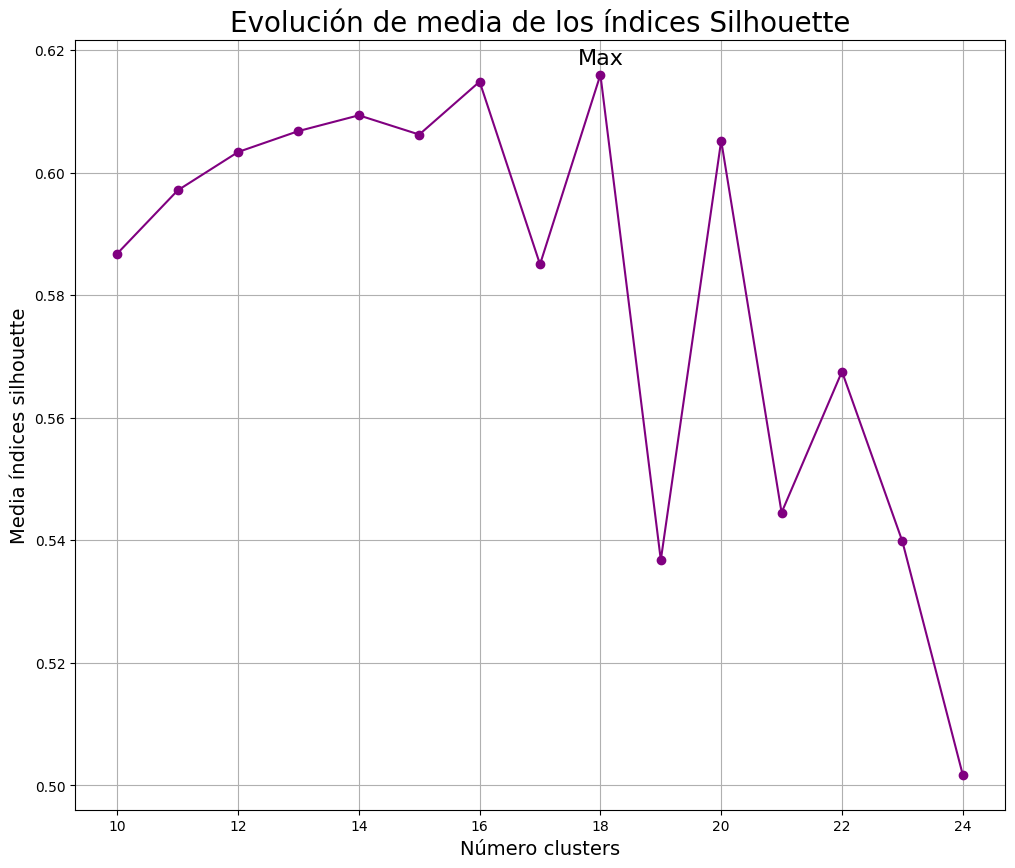

In [155]:
range_n_clusters = range(10, 25)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 25,
        random_state = 49
    )
    cluster_labels = modelo_kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Encontrar el número de clústeres con la puntuación de silueta máxima
max_silhouette_idx = np.argmax(valores_medios_silhouette)
max_silhouette_score = valores_medios_silhouette[max_silhouette_idx]
best_n_clusters = range_n_clusters[max_silhouette_idx]

# Graficar
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o', color='purple')
ax.set_title("Evolución de media de los índices Silhouette", size=20)
ax.set_xlabel('Número clusters', size=14)
ax.set_ylabel('Media índices silhouette', size=14)

# Mejor número de clusters
ax.text(best_n_clusters, max_silhouette_score+0.001, f'Max', 
        verticalalignment='bottom', horizontalalignment='center', fontsize=16)

# Agregar una cuadrícula
ax.grid(True)

plt.show()

Obtenemos que el mejor *silhouette* se obtiene con 18 clusters.

In [156]:
# Modelo de sklearn
kmeans_sklearn = KMeans(n_clusters=18, n_init=25, random_state=49)
# Entrenar el modelo
t_inicio = time.time_ns()
kmeans_sklearn.fit(X_scaled)
t_fin = time.time_ns()
# Tiempo de entrenamiento
t_sklearn = t_fin - t_inicio


In [157]:
# Predicciones
labels_sklearn = kmeans_sklearn.predict(X=X_scaled)

In [158]:
# Calcular el índice de Silhouette
silueta_sklearn = silhouette_score(X_scaled, labels_sklearn)

**KMeans implementado**

In [159]:
# Modelo implementado por nosotros
kmeans_custom = MiKMeans(n_clusters=18)
# Entrenar el modelo
t_inicio = time.time_ns()
kmeans_custom.fit(X_scaled)
t_fin = time.time_ns()
# Tiempo de entrenamiento
t_custom = t_fin - t_inicio

In [160]:
# Predicciones
labels_custom = kmeans_custom.predict(X=X_scaled)

In [161]:
# Calcular el índice de Silhouette
silueta_custom = silhouette_score(X_scaled, labels_custom)

**Resultados**

In [162]:
# Mostrar resultados
print(f"KMeans de sklearn:")
print(f"Tiempo de entrenamiento: {t_sklearn:.2f} s")
print(f"Índice de Silhouette: {silueta_sklearn:.2f}")
print()
print(f"KMeans implementado por nosotros:")
print(f"Tiempo de entrenamiento: {t_custom:.2f} s")
print(f"Índice de Silhouette: {silueta_custom:.2f}")

KMeans de sklearn:
Tiempo de entrenamiento: 57408000.00 s
Índice de Silhouette: 0.62

KMeans implementado por nosotros:
Tiempo de entrenamiento: 4242000.00 s
Índice de Silhouette: 0.40


In [164]:
pd.crosstab(labels_sklearn, labels_custom, dropna=False, rownames=['sklearn'], colnames=['nuestro'])

nuestro,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
sklearn,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0
1,0,18,0,23,0,10,0,0,0,10,9,0,0,0,0,8,3,0
2,0,0,0,0,0,0,0,0,6,0,0,0,0,7,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0
4,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,7,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
8,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0
